# COVID-19 Exploratory Data Analysis (EDA)

Plotting some COVID-19 data, focusing on local reagions and looking for turning points.

## Dashboards
There are many places to view COVID-19 data:
- https://www.cdc.gov/coronavirus/2019-ncov/cases-updates/cases-in-us.html
- https://www.ft.com/coronavirus-latest
- https://coronavirus.jhu.edu/map.html
- https://gisanddata.maps.arcgis.com/apps/opsdashboard/
- https://www.worldometers.info/coronavirus/
- https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/
- https://nssac.bii.virginia.edu/covid-19/dashboard/
- https://www.statnews.com/2020/03/26/covid-19-tracker/
- https://ncov2019.live/

And data sources:
- https://data.world/resources/coronavirus/
- https://github.com/CSSEGISandData/COVID-19/
- https://www.tableau.com/covid-19-coronavirus-data-resources
- https://github.com/nytimes/covid-19-data

**Here we the USAFacts and NYTimes data**

In [3]:
# hide

import requests
import io
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

## USAFacts State Data

In [4]:
# hide
confirmed_url = 'https://static.usafacts.org/public/data/covid-19/covid_confirmed_usafacts.csv'
deaths_url = 'https://static.usafacts.org/public/data/covid-19/covid_deaths_usafacts.csv'

response = requests.get(confirmed_url)
file_object = io.StringIO(response.content.decode('utf-8'))
confirmed = pd.read_csv(file_object, thousands=',')
confirmed.shape

response = requests.get(deaths_url)
file_object = io.StringIO(response.content.decode('utf-8'))
deaths = pd.read_csv(file_object, thousands=',')
deaths.shape

(3195, 74)

In [5]:
# hide
def adjust_df(df):
    df = df.drop(df.filter(like='Unnamed').columns, axis=1) # drop spurious empty columns
    df = df.drop(df.index[df.countyFIPS.isnull()])          # drop spurious empty rows
    df = df.drop(['countyFIPS','stateFIPS'], axis=1)
    df = df.rename(columns={'County Name': 'County'})       # drop 'County' from column names
    df = df.set_index(['State','County'])
    df = df.T
    df = df.rename(columns=lambda x: x.replace(' County',''))
    df.index = pd.to_datetime(df.index)
    return df

In [6]:
confirmed = adjust_df(confirmed)
deaths    = adjust_df(deaths)

In [7]:
annotate = dict(
    s='Based on USAFacts COVID Data ({})'.format(confirmed.index.max().strftime('%B %d, %Y')), 
    xy=(0.2, 0.05), xycoords='figure fraction', fontsize=10)

## US States Data

In [53]:
states_conf = confirmed.groupby(level=0, axis=1).sum()
states_dths = deaths.groupby(level=0, axis=1).sum()

In [46]:
top_states = states_conf.tail(1)
day = top_states.index[0]
top_states = top_states.T
top_states = top_states.sort_values(by=day, ascending=False).index[:3]
top_states

Index(['NY', 'NJ', 'CA'], dtype='object', name='State')

In [69]:
# hide

def plot_states(df, figsize=(12,8)):
    fig, ax = plt.subplots()
    ax = df.plot(title='Confirmed COVID19 cases by State', legend=True, figsize=figsize, ax=ax)
    top_states = df.tail(1)
    day = top_states.index[0]
    top_states = top_states.T
    top_states = top_states.sort_values(by=day, ascending=False).index[:3]
    top_points = df[top_states].tail(1)
    top_points.plot(ax=ax, style='ro')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.legend(loc='upper left', ncol=4)
    ax.grid('on', which='major', axis='y')
    for state, y in zip(list(top_points.columns), top_points.values[0]):
        plt.text(day, y, state)
    return ax

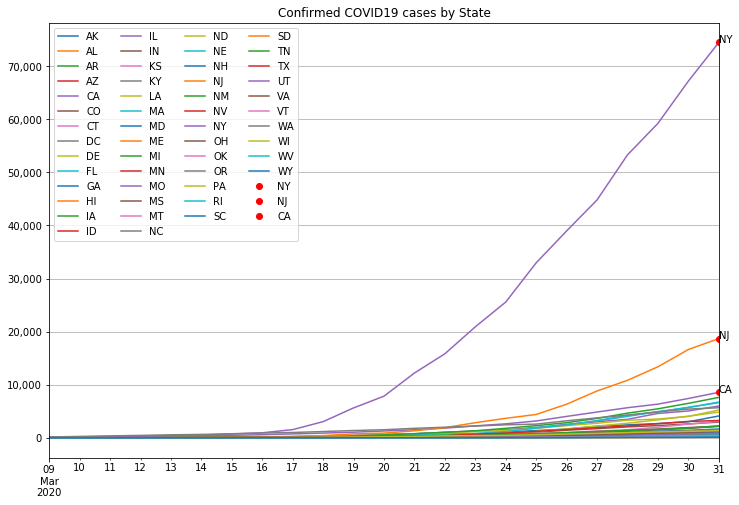

In [70]:
ax = plot_states(states_conf.loc['2020-03-09':,])

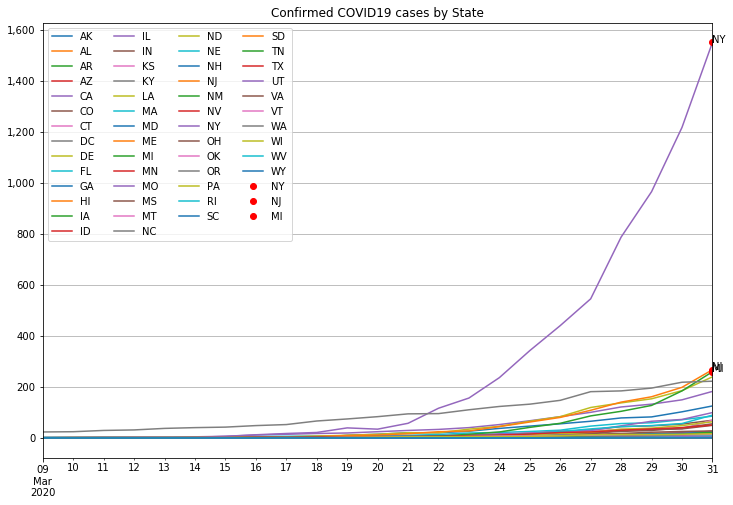

In [71]:
ax = plot_states(states_dths.loc['2020-03-09':,])

## NY Data

Double check with raw data from the following sources:
-  https://coronavirus.health.ny.gov/county-county-breakdown-positive-cases
- https://www1.nyc.gov/site/doh/covid/covid-19-data.page

In [87]:
# hide
def plot_state(df, state='NY', county=None, label='confirmed', from_date='2020-03-09', figsize=(12,8)):
    days = df.loc[from_date:,].index
    df = df[state].loc[from_date:,]
    
    fig, ax = plt.subplots()
    ax = df.loc[from_date:,].plot(title=state+' COVID19 '+label+' by County', figsize=figsize, ax=ax)
    ax.legend(loc='upper left', ncol=3)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.grid('on', which='major', axis='y')

    last_date = df[-1:].index[0]
    top_state_counties = list(df.sort_values(by=last_date, axis=1, ascending=False).columns[:10])
    if county == None:
        top_county = top_state_counties[0]
    else:
        top_county = county
    
    fig, ax = plt.subplots()
    ax = df.loc[from_date:,top_state_counties].plot(title='top '+state+' COVID19 '+label+' by county', figsize=figsize, ax=ax)
    ax.legend(loc='upper left', ncol=2)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.grid('on', which='major', axis='y')

    return ax

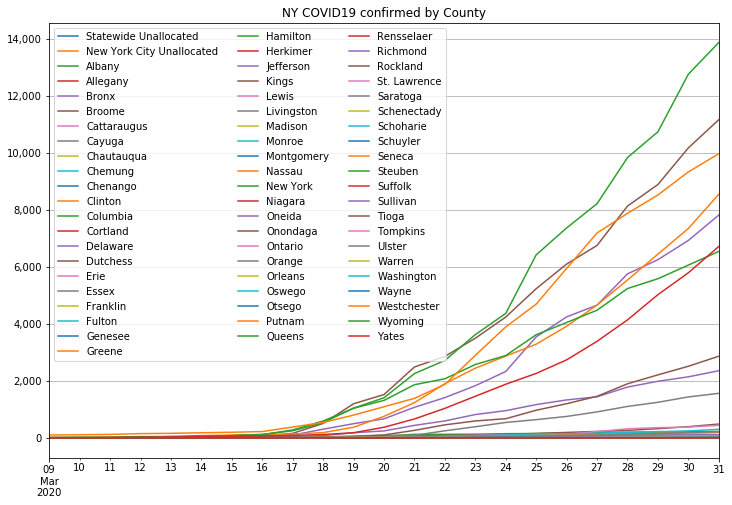

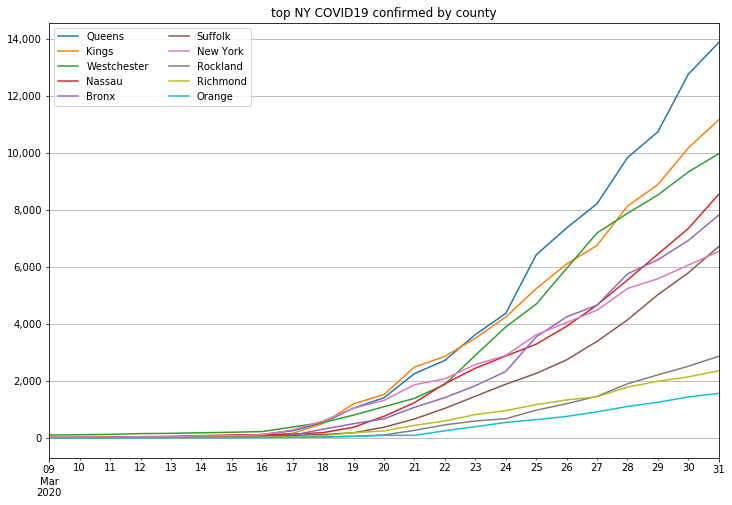

In [88]:
ax = plot_state(confirmed)
ax.get_figure().savefig('NY_confirmed.png')

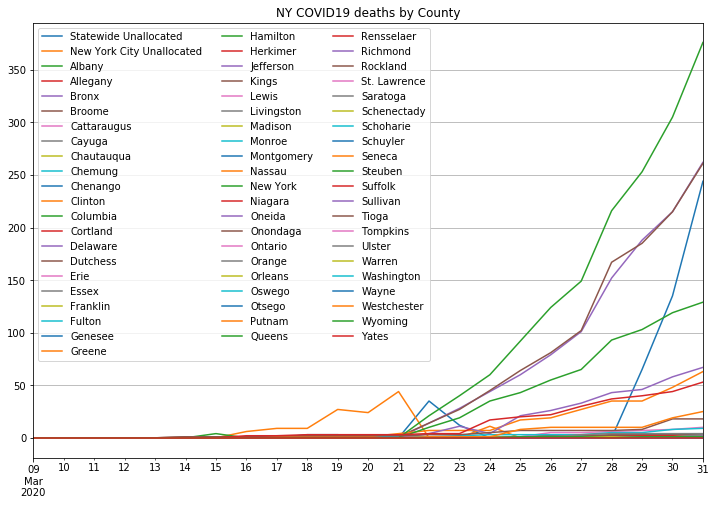

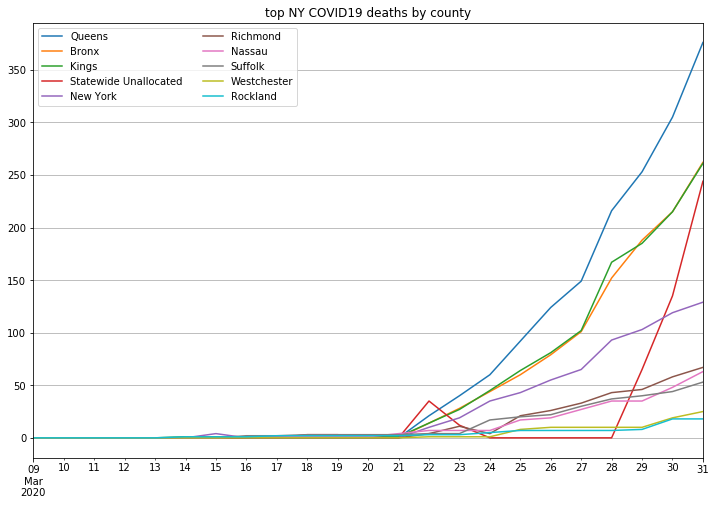

In [89]:
ax = plot_state(deaths, label='deaths')
ax.get_figure().savefig('NY_deaths.png')

In [126]:
# hide

def setup(ax):
    # from https://matplotlib.org/3.1.1/gallery/ticks_and_spines/tick-formatters.html
    ax.grid('on', which='major', axis='x' )
    ax.grid('on', which='major', axis='y' )
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
def plot_county(conf, dths, state='NY', county='Queens', from_date='2020-03-09', figsize=(12,16)):
    days = conf.loc[from_date:,].index
    conf = conf[state,county].loc[from_date:,]
    dths = dths[state,county].loc[from_date:,]
    
    fig, ax = plt.subplots(3,1)
    fig.subplots_adjust(hspace=0.3)
    conf_label = 'confirmed '+str(format(conf.iloc[-1],','))
    dths_label = 'deaths '+str(format(dths.iloc[-1],','))
    ax[0] = conf.loc[from_date:].plot(title=county+' COVID19 cumulative count', label=conf_label, c='b', 
                                            legend=True, figsize=figsize, ax=ax[0])
    ax[0] = dths.loc[from_date:].plot(label=dths_label, c='r', legend=True, ax=ax[0])
    ax[0].set_xticks(days, minor=True )
    setup(ax[0])

    label='confirmed '+str(format(int(round(conf.loc[from_date:].diff().iloc[-1])),','))
    dths_label='deaths '+str(format(int(round(dths.loc[from_date:].diff().iloc[-1])),','))
    ax[1] = conf.loc[from_date:].diff().plot(title=county+' COVID19 confirmed daily count', label=label, c='b', 
                                                    legend=True, ax=ax[1])
    ax[1] = dths.loc[from_date:].diff().plot(label=dths_label, legend=True, c='r', ax=ax[1])
    ax[1].set_xticks(days, minor=True )
    setup(ax[1])

    conf_label='confirmed '+str(format(round(conf.loc[from_date:].pct_change().iloc[-1]*100,2),','))+'%'
    dths_label='deaths '+str(format(round(dths.loc[from_date:].pct_change().iloc[-1]*100,2),','))+'%'
    ax[2] = conf.loc[from_date:].pct_change().plot(title=county+' COVID19 confirmed daily % change', 
                                                          label=conf_label, c='b', legend=True, ax=ax[2])
    ax[2] = dths.loc[from_date:].pct_change().plot(label=dths_label, c='r', legend=True, ax=ax[2])
    ax[2].set_xticks( days, minor=True )
    setup(ax[2])
    ax[2].annotate(**annotate)
    
    return ax

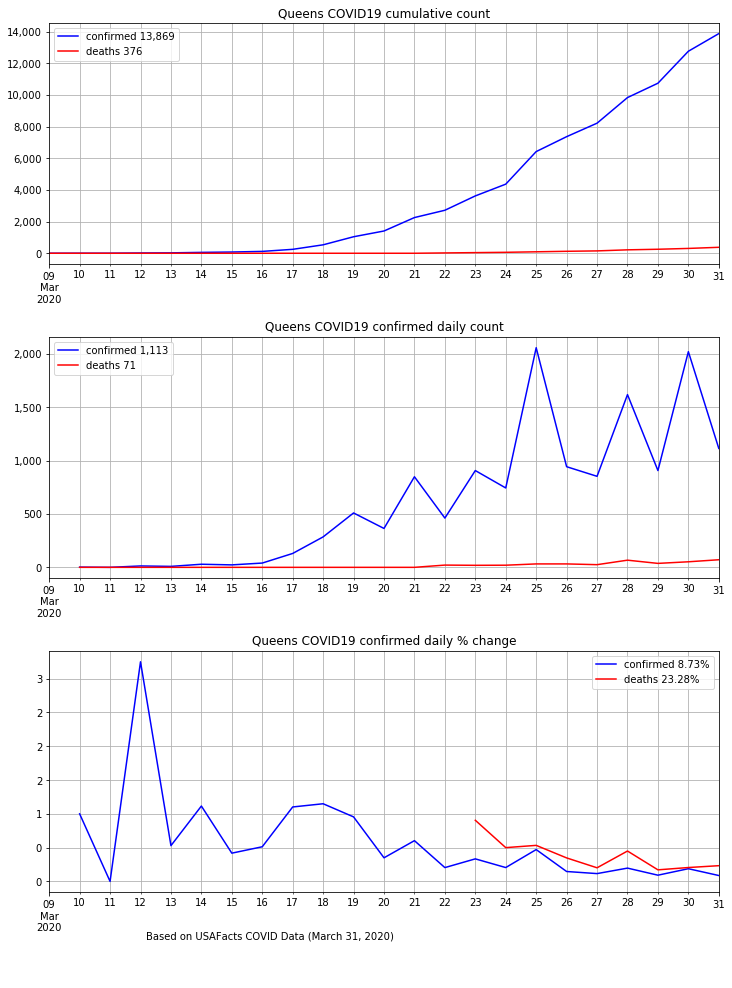

In [121]:
ax = plot_county(confirmed, deaths, 'NY','Queens')
ax[0].get_figure().savefig('Queens_COVID19_count.png')

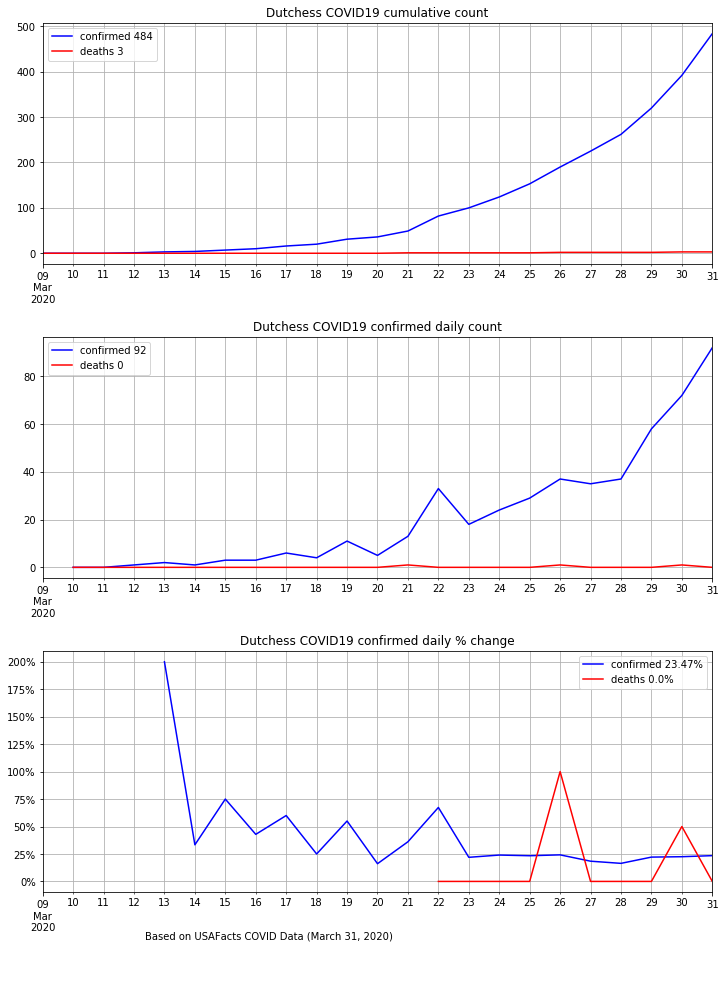

In [38]:
fig = plot_county(confirmed, deaths, 'NY', 'Dutchess' )
ax[0].get_figure().savefig('Dutchess_COVID19_count.png')

## LogLog Plot
- [YouTube: How To Tell If We're Beating COVID-19](https://www.youtube.com/watch?v=54XLXg4fYsc) and [Graph](https://aatishb.com/covidtrends/)

In [123]:
# hide
def new_total_plot(df, label='confirmed', figsize=(10,10)):
    df = df.replace(0, np.nan)
    df_diff = df.diff(axis=0).rolling(window=7).mean()
    df_diff = df_diff.replace(0.0, np.nan)

    fig, ax = plt.subplots()
    for c in df.columns:
        line = pd.DataFrame([df[c].values, df_diff[c].values])
        line = line.T
        line.columns = ['total cases',c]
        line = line[line > 10]  # line is noisy at less than 10
        line = line.dropna()    # so drop these point
        if line.shape[0] == 0:  # if line is empty, skip it
            continue
        line = line.set_index('total cases')
        line.name = c
        ax = line.plot(ax=ax, label=c, loglog=True, legend=False, figsize=figsize, c='grey') 
        last_point = line.tail(1)
        x = last_point.index[0]
        y = last_point.values[0][0]
        if x < 0:
            x = 0.0
        if y < 0:
            y = 0.0
        if x > 10 and y > 10:
            last_point.plot(ax=ax, style='ro', legend=False)
            plt.text(x,y, c)
        # ax.legend(loc='upper left', ncol=3)

    ax.set_title('Tragectory of COVID-19 '+label+' cases '+str(df.tail(1).index[0].date()))
    setup(ax)
    xticks, xticklabels = plt.xticks()
    xmin = 50
    xmax = df.max().max() + 2000
    plt.xlim(xmin, xmax)
    plt.xlabel('total '+label)
    plt.ylabel('new '+label+' (averaged over the week)')
    return ax

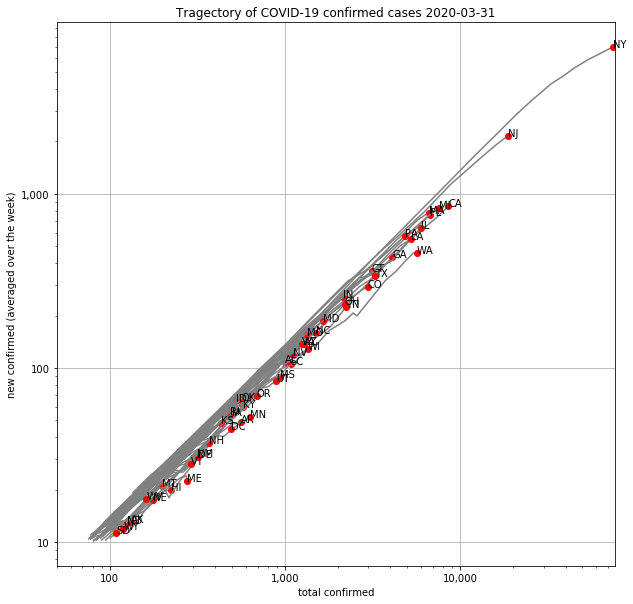

In [127]:
ax = new_total_plot(states_conf)
ax.get_figure().savefig('states_trajectory.png')

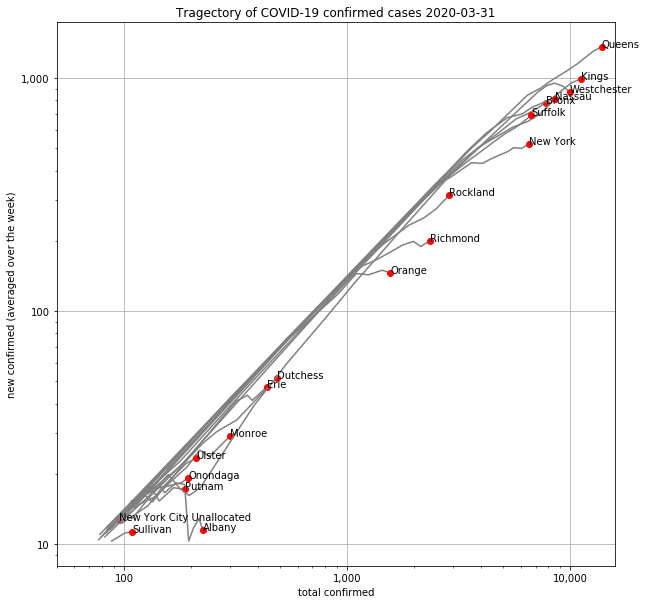

In [128]:
ax = new_total_plot(confirmed['NY'])
ax.get_figure().savefig('NY_trajectory.png')

## NYC Data

In [157]:
# hide
def setup(ax):
    # from https://matplotlib.org/3.1.1/gallery/ticks_and_spines/tick-formatters.html
    ax.grid('on', which='major', axis='y' )
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [148]:
ny_confirmed = confirmed['NY'].loc['2020-03-09':]
ny_confirmed.index = ny_confirmed.index.date
ny_deaths = deaths['NY'].loc['2020-03-09':]
ny_deaths.index = ny_deaths.index.date

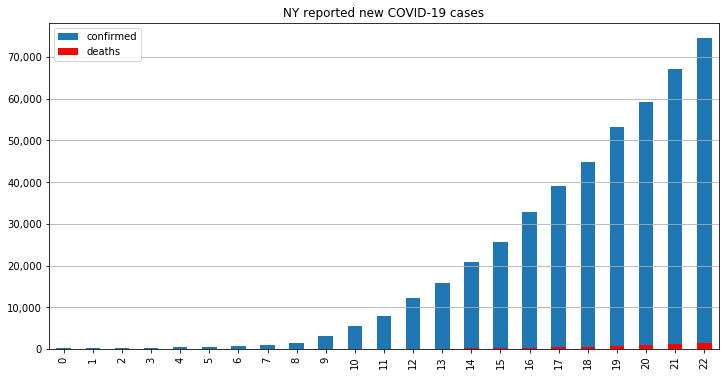

In [168]:
ax = ny_confirmed.sum(axis=1).plot.bar(title='NY reported new COVID-19 cases', figsize=(12,6), legend=True, label='confirmed')
ax = ny_deaths.sum(axis=1).plot.bar(color='r', legend=True, label='deaths')
setup(ax)

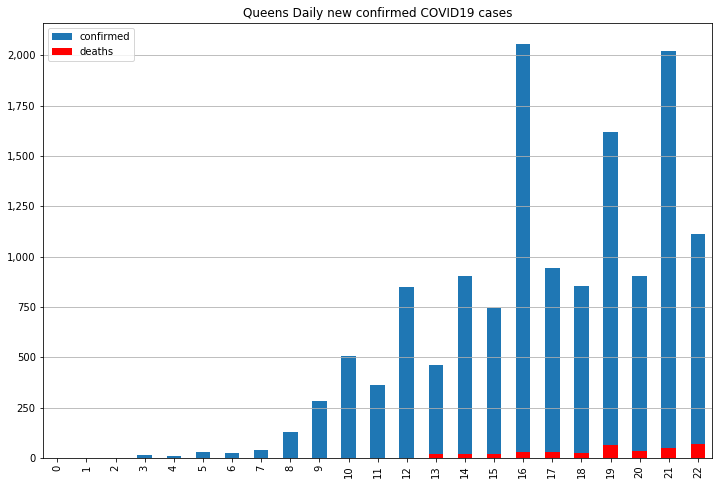

In [167]:
county = 'Queens'
ax = ny_confirmed[county].diff().plot.bar(figsize=figsize, title=county+' Daily new confirmed COVID19 cases', label='confirmed', legend=True)
ax = ny_deaths[county].diff().plot.bar(stacked=True, color='r', label='deaths', legend=True)
setup(ax)

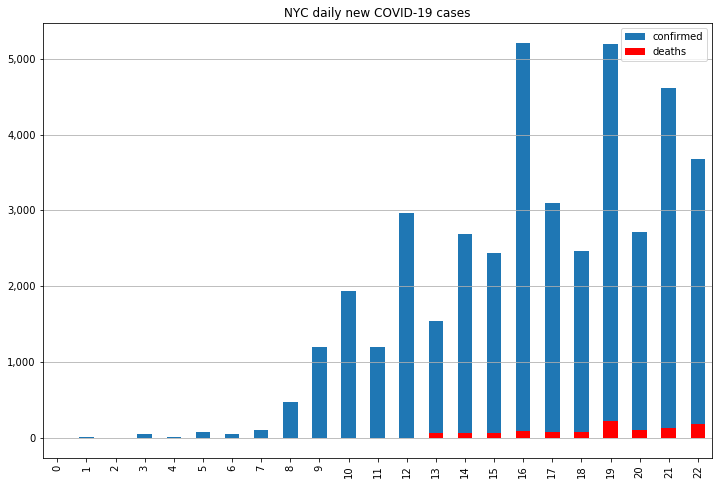

In [164]:
fig, ax = plt.subplots()
nyc = ['New York', 'Queens', 'Kings', 'Bronx', 'Richmond']
ax = ny_confirmed[nyc].sum(axis=1).diff().plot.bar(title='NYC daily new COVID-19 cases', figsize=figsize, legend=True, label='confirmed')
ax = ny_deaths[nyc].sum(axis=1).diff().plot.bar(stacked=True, color='r', label='deaths', legend=True)
setup(ax)
fig.savefig('nyc_daily.png')